<a href="https://colab.research.google.com/github/AndresCesana/Electronica-Analogica-III/blob/main/Calculos_EAIII_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalar y dar acceso en drive**

In [1]:
#Esta parte se corre una sola vez al iniciar la sesion
!pip install scikit-rf
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.1/615.1 kB 14.6 MB/s eta 0:00:00
Mounted at /content/drive


**Cargar parámetros y recuperar los S**

In [3]:
import os
import numpy as np
from skrf import Network

def calcular_parametros_s(frecuencia, carpetas):
    parametros_s = {}
    frecuencia *= 1e9  # GHz a Hz

    for carpeta in carpetas:
        if not os.path.exists(carpeta):
            print(f"Carpeta no encontrada: {carpeta}")
            continue

        archivos_s2p = [f for f in os.listdir(carpeta) if f.endswith('.s2p')]

        for archivo_s2p in archivos_s2p:
            ruta_archivo = os.path.join(carpeta, archivo_s2p)
            red = Network(ruta_archivo)

            indice_frecuencia = np.argmin(np.abs(red.f - frecuencia))
            if archivo_s2p not in parametros_s:
                parametros_s[archivo_s2p] = red.s[indice_frecuencia]

    return parametros_s

carpetas = ['/content/drive/MyDrive/UNC/carpeta']
frecuencia = 2 # GHz
parametros_s = calcular_parametros_s(frecuencia, carpetas)
for nombre_archivo, matriz_s in parametros_s.items():
    print(f"\nArchivo: {nombre_archivo}")
    print("Matriz S en la frecuencia seleccionada:")
    print(matriz_s)
    print("Cantidad de parámetros S cargados:", len(parametros_s))
    print(f"Tamaño de parametros_s: {len(parametros_s)}")
    print(parametros_s)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
       [ 0.36560713+10.4696183j ,  0.21870034 -0.32917047j]]), 'BFP640_w_noise_VCE_3.5V_IC_2.0mA.s2p': array([[ 0.05410927-0.75486318j,  0.07334561+0.06286479j],
       [-2.21071613+4.74089603j,  0.58624551-0.47813017j]]), 'BFP640_w_noise_VCE_3.5V_IC_30mA.s2p': array([[-0.26785511 -0.01544443j,  0.0272822  +0.04106302j],
       [ 2.46616037+11.40644349j,  0.14879184 -0.19602601j]]), 'BFP640_w_noise_VCE_3.0V_IC_6.0mA.s2p': array([[-0.24332595-0.43897163j,  0.05478746+0.04405025j],
       [-0.93839307+9.08064202j,  0.30020486-0.41017793j]]), 'BFP640_w_noise_VCE_3.0V_IC_8.0mA.s2p': array([[-0.27605795-0.33488507j,  0.04815047+0.04185657j],
       [-0.19080338+9.93716836j,  0.24271753-0.36531926j]]), 'BFP640_w_noise_VCE_3.0V_IC_45mA.s2p': array([[-0.28691378 +0.05317633j,  0.02445501 +0.04118692j],
       [ 2.85230733+10.79554996j,  0.14422194 -0.16187116j]]), 'BFP640_w_noise_VCE_3.5V_IC_15mA.s2p': array([[-0.28517398 -0.14

# **Cálculo del delta**

In [4]:
def calcular_delta_y_guardar(parametros_s):
    deltas = {}
    polarizaciones_buenas_delta = {}

    for archivo, parametros in parametros_s.items():
        s11, s12, s21, s22 = parametros[0, 0], parametros[0, 1], parametros[1, 0], parametros[1, 1]
        delta = (s11 * s22) - (s12 * s21)
        deltas[archivo] = delta

        if abs(delta) < 1:
            polarizaciones_buenas_delta[archivo] = {'delta': delta}

    return deltas, polarizaciones_buenas_delta

# **Cáclulo de K**

In [5]:
import pandas as pd

def calcular_k_y_guardar(parametros_s, deltas, polarizaciones_buenas_k):
    ks = {}
    data = []  # Lista para almacenar los valores de Vce, Ic, k y parámetros S de solo los estables

    for archivo, parametros in parametros_s.items():
        # Obtén los valores de S
        S11 = parametros[0, 0]
        S12 = parametros[0, 1]
        S21 = parametros[1, 0]
        S22 = parametros[1, 1]
        abs_delta = abs(deltas[archivo])

        # Calcular el parámetro k
        numerador = (1 - abs(S11)**2 - abs(S22)**2 + abs_delta**2)
        denominador = 2 * abs(S12 * S21)
        k = numerador / denominador

        ks[archivo] = k

        # Extraer Ic y Vce desde el nombre del archivo
        ic = float(archivo.split('_IC_')[1].split('mA')[0])
        vce = float(archivo.split('_VCE_')[1].split('V')[0])

        # Solo agregar los valores estables (k > 1) al DataFrame
        if k > 1:
            polarizaciones_buenas_k[archivo] = {'k': k, 'delta': deltas[archivo]}
            # Agregar los valores junto con los parámetros S
            data.append([vce, ic, k, f"{S11:.6f}", f"{S12:.6f}", f"{S21:.6f}", f"{S22:.6f}"])  # Solo agrega si es estable

    # Crear un DataFrame con la información de Vce, Ic, k y los parámetros S
    df = pd.DataFrame(data, columns=["Vce (V)", "Ic (mA)", "K", "S11", "S12", "S21", "S22"])

    # Ajustamos el formato de impresión para evitar columnas vacías
    print("\n--- DataFrame de Vce, Ic, K y Parámetros S (Solo Estables) ---")
    print(df.to_string(index=False, header=True, line_width=150))

    return ks, polarizaciones_buenas_k, df

# Llamada a la función
deltas, polarizaciones_buenas = calcular_delta_y_guardar(parametros_s)
ks, polarizaciones_buenas_k, df = calcular_k_y_guardar(parametros_s, deltas, polarizaciones_buenas)

# Imprimir los resultados
print("\n--- Resultados de Delta y K combinados ---")
for archivo in parametros_s.keys():
    delta = deltas[archivo]
    k = ks[archivo]
    mensaje = f"{archivo}: Δ = {delta:.4f} (|Δ| = {abs(delta):.4f}) - K = {k:.4f}"
    if k > 1:
        mensaje += " - Incondicionalmente estable"
    else:
        mensaje += " - Inestable"
    print(mensaje)



--- DataFrame de Vce, Ic, K y Parámetros S (Solo Estables) ---
 Vce (V)  Ic (mA)        K                 S11                S12                 S21                 S22
     1.0     40.0 1.464102 -0.638650+0.296451j 0.036652+0.044305j  1.157318+2.968368j  0.009191+0.003939j
     1.0     45.0 1.706405 -0.675547+0.351668j 0.037004+0.045696j  0.898481+2.018022j -0.019690+0.034242j
     1.0     30.0 1.018891 -0.405487+0.086929j 0.034184+0.044229j  2.613511+8.548408j  0.029649-0.128422j
     1.0     35.0 1.162053 -0.534612+0.209512j 0.035520+0.043552j  1.957182+5.406657j  0.028164-0.056242j
     1.5     40.0 1.094784 -0.444282+0.152112j 0.028893+0.041418j  2.415820+7.391210j  0.107085-0.110117j
     1.5     45.0 1.284903 -0.564021+0.246415j 0.029767+0.040671j  1.611258+4.601030j  0.114731-0.062813j
     1.5     35.0 1.014801 -0.342697+0.061661j 0.028873+0.042645j  2.750383+9.784799j  0.094855-0.152390j
     2.0     35.0 1.002726 -0.294237+0.027296j 0.027232+0.041934j 2.737385+10.818041j  0

**Gráficas de resultados**

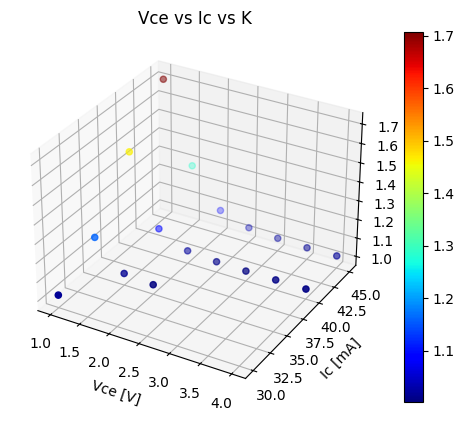

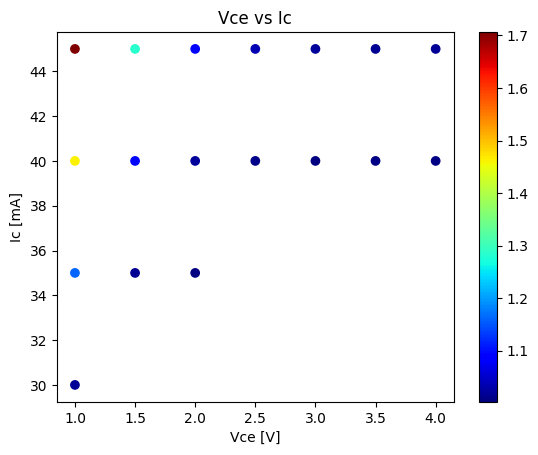

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Convertir columnas numéricas al tipo correcto
df['Vce (V)'] = df['Vce (V)'].astype(float)
df['Ic (mA)'] = df['Ic (mA)'].astype(float)
df['K'] = df['K'].astype(float)

# Gráfico 3D de Ic, Vce y K (intercambiando ejes)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['Vce (V)'], df['Ic (mA)'], df['K'], c=df['K'], cmap=cm.jet)
plt.colorbar(sc)
ax.set_xlabel('Vce [V]')
ax.set_ylabel('Ic [mA]')
ax.set_zlabel('K')
plt.title('Vce vs Ic vs K')
plt.show()

# Gráfico 2D térmico de Vce e Ic vs K
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(df['Vce (V)'], df['Ic (mA)'], c=df['K'], cmap=cm.jet)
plt.colorbar(sc)
ax.set_xlabel('Vce [V]')
ax.set_ylabel('Ic [mA]')
plt.title('Vce vs Ic')
plt.show()


In [7]:
import numpy as np
import pandas as pd

def calcular_impedancias_y_guardar(df, frecuencia_hz=2e9, Zo=50):
    gamma_in_list = []
    gamma_out_list = []
    Z_in_trafo_list = []
    C_in_list = []
    Z_out_trafo_list = []
    C_out_list = []
    L_out_p_list = []
    vce_list = []
    ic_list = []
    k_list = []
    s11_list = []
    s12_list = []
    s21_list = []
    s22_list = []

    for index, row in df.iterrows():
        s11 = complex(row['S11'])
        s12 = complex(row['S12'])
        s21 = complex(row['S21'])
        s22 = complex(row['S22'])
        det = (s11 * s22) - (s12 * s21)

        B1 = 1 + abs(s11)**2 - abs(s22)**2 - abs(det)**2
        B2 = 1 + abs(s22)**2 - abs(s11)**2 - abs(det)**2
        C1 = s11 - det * np.conjugate(s22)
        C2 = s22 - det * np.conjugate(s11)

        # Cálculo de gamma in
        discriminante_in = (B1**2) - (4 * (abs(C1)**2))
        if discriminante_in >= 0 and abs(C1) != 0:
            gamma_in = (B1 - np.sqrt(discriminante_in)) / (2 * abs(C1))
        else:
            gamma_in = np.nan
        gamma_in_list.append(gamma_in)

        # Cálculo de gamma out
        discriminante_out = (B2**2) - (4 * (abs(C2)**2))
        if discriminante_out >= 0 and abs(C2) != 0:
            gamma_out = (B2 - np.sqrt(discriminante_out)) / (2 * abs(C2))
        else:
            gamma_out = np.nan
        gamma_out_list.append(gamma_out)

        # Cálculo de impedancias de entrada
        if not np.isnan(gamma_in):
            gamma_in_rect = gamma_in * np.cos(np.angle(C1)) + gamma_in * np.sin(np.angle(C1)) * 1j
            Z_in = Zo * ((1 + gamma_in_rect) / (1 - gamma_in_rect))
            if np.real(Z_in) != 0:
                Z_in_p_real = np.real(Z_in) * (1 + (np.imag(Z_in) / np.real(Z_in))**2)
            else:
                Z_in_p_real = np.inf
            if np.imag(Z_in) != 0:
                Z_in_p_imag = np.imag(Z_in) * (1 + (np.real(Z_in) / np.imag(Z_in))**2) * 1j
            else:
                Z_in_p_imag = np.inf * 1j
            Z_in_p = Z_in_p_real + Z_in_p_imag
            Z_in_trafo = np.sqrt(Zo * np.real(Z_in_p)) if np.real(Z_in_p) >= 0 else np.nan
            C_in = 1 / (2 * np.pi * frecuencia_hz * np.imag(Z_in_p)) if np.imag(Z_in_p) != 0 else np.nan
        else:
            Z_in_trafo = np.nan
            C_in = np.nan
        Z_in_trafo_list.append(Z_in_trafo)
        C_in_list.append(C_in)

        # Cálculo de impedancias de salida
        if not np.isnan(gamma_out):
            gamma_out_rect = gamma_out * np.cos(np.angle(C2)) + gamma_out * np.sin(np.angle(C2)) * 1j
            Z_out = Zo * ((1 + gamma_out_rect) / (1 - gamma_out_rect))
            if np.real(Z_out) != 0:
                Z_out_p_real = np.real(Z_out) * (1 + (np.imag(Z_out) / np.real(Z_out))**2)
            else:
                Z_out_p_real = np.inf
            if np.imag(Z_out) != 0:
                Z_out_p_imag = np.imag(Z_out) * (1 + (np.real(Z_out) / np.imag(Z_out))**2) * 1j
            else:
                Z_out_p_imag = np.inf * 1j
            Z_out_p = Z_out_p_real + Z_out_p_imag
            Z_out_trafo = np.sqrt(Zo * np.real(Z_out)) if np.real(Z_out) >= 0 else np.nan
            L_out_p = (Z_out_trafo**2) / np.imag(Z_out) if np.imag(Z_out) != 0 and Z_out_trafo is not np.nan else np.nan
            C_out = 1 / (2 * np.pi * frecuencia_hz * abs(L_out_p)) if L_out_p is not np.nan and frecuencia_hz != 0 else np.nan
        else:
            Z_out_trafo = np.nan
            L_out_p = np.nan
            C_out = np.nan
        Z_out_trafo_list.append(Z_out_trafo)
        C_out_list.append(C_out)
        L_out_p_list.append(L_out_p)
        vce_list.append(row['Vce (V)'])
        ic_list.append(row['Ic (mA)'])
        k_list.append(row['K'])
        s11_list.append(row['S11'])
        s12_list.append(row['S12'])
        s21_list.append(row['S21'])
        s22_list.append(row['S22'])

    valores_calculados = pd.DataFrame({
        'Vce (V)': vce_list,
        'Ic (mA)': ic_list,
        'K': k_list,
        'S11': s11_list,
        'S12': s12_list,
        'S21': s21_list,
        'S22': s22_list,
        'Gamma_in': gamma_in_list,
        'Gamma_out': gamma_out_list,
        'Z_in_trafo (Ohm)': Z_in_trafo_list,
        'C_in (F)': C_in_list,
        'Z_out_trafo (Ohm)': Z_out_trafo_list,
        'C_out (F)': C_out_list,
        'L_out_p (H)': L_out_p_list
    })

    print("\n--- DataFrame de Valores Calculados ---")
    # Aumentamos el ancho de la línea para intentar imprimir todo horizontalmente
    print(valores_calculados.to_string(index=False, header=True, line_width=500))

    return valores_calculados

# Llamada a la función para calcular las impedancias y guardar en 'valores_calculados'
frecuencia = 2.0e9  # 2 GHz en Hz
Zo = 50             # Impedancia característica en Ohm
valores_calculados = calcular_impedancias_y_guardar(df.copy(), frecuencia, Zo)


--- DataFrame de Valores Calculados ---
 Vce (V)  Ic (mA)        K                 S11                S12                 S21                 S22  Gamma_in  Gamma_out  Z_in_trafo (Ohm)     C_in (F)  Z_out_trafo (Ohm)    C_out (F)  L_out_p (H)
     1.0     40.0 1.464102 -0.638650+0.296451j 0.036652+0.044305j  1.157318+2.968368j  0.009191+0.003939j  0.760002   0.304774         34.433086 5.108957e-12          62.090728 5.998079e-13  -132.671602
     1.0     45.0 1.706405 -0.675547+0.351668j 0.037004+0.045696j  0.898481+2.018022j -0.019690+0.034242j  0.790209   0.222599         38.670376 5.198042e-12          59.681002 3.816311e-13  -208.519330
     1.0     30.0 1.018891 -0.405487+0.086929j 0.034184+0.044229j  2.613511+8.548408j  0.029649-0.128422j  0.811302   0.728928         19.021515 6.808837e-12          41.479463 4.021336e-12   -19.788813
     1.0     35.0 1.162053 -0.534612+0.209512j 0.035520+0.043552j  1.957182+5.406657j  0.028164-0.056242j  0.727157   0.461449         29.759382 4.

In [8]:
import numpy as np
import pandas as pd

def Hammerstad(epsilom = 4.5, h = 1.55, t = 0.031, zo = 50, frecuencia_ghz = 2.0):
    frecuencia_mhz = frecuencia_ghz * 1000  # Convert GHz to MHz

    A = zo/60*np.sqrt((epsilom + 1)/2) + (epsilom - 1)/(epsilom + 1)*(0.23 + 0.11/epsilom)
    B = 377*np.pi/(2*zo*np.sqrt(epsilom))

    # Para W/h <= 2
    W_h_1 = (8*np.exp(A)/(np.exp(2*A) - 2))
    W_h_2 = (2/np.pi*(B-1-np.log(2*B-1) + (epsilom - 1)/(2*epsilom)*(np.log(B-1) + 0.39 - 0.61/epsilom)))

    if W_h_1 <= 2:
        w_h = W_h_1
    else:
        w_h = W_h_2

    W = w_h*h

    # calculo de We
    if W/h >= (0.5*np.pi):
        We = W + (t/np.pi)*(1 + np.log(2*h/t))
    else:
        We = W + (t/np.pi)*(1 + np.log(4*np.pi*W/t))

    # Correccion de Er
    if W/h >= 1:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*(1/(np.sqrt(1 + 12*h/W)))
    else:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*((1/(np.sqrt(1 + 12*h/W))) + 0.04*(1 - W/h)**2)

    # lamda real = 300 / f donde f es la frecuencia en MHz y nos da lambda en metros
    lambda_real = 300/frecuencia_mhz
    lambda_eff = lambda_real/(np.sqrt(epsilom_eff))

    # beta in
    beta_in = 2*np.pi/lambda_eff # es el beta de la linea de transmision

    return We, lambda_eff, beta_in

def microtiras(Z=50, er=4.3, H=1.55, t=0.031, frecuencia=2, tipo="T", C=None):

    We, lambda_p, beta = Hammerstad(er, H, t, Z, frecuencia)
    #print("We (mm): ", We * 1000) # Convert to mm

    if(tipo == "T"):
        # Largo de la microtira (cuarto de onda)
        largo = lambda_p/4 * 1000 # Convert to mm

    elif(tipo == "C"):
        X_c = 1/(2*np.pi*frecuencia*1e9*C)
        Z_d   = X_c
        d     = (np.arctan(Z/Z_d)) / beta
        angulo = beta * d * 180/(np.pi)

        print("Ángulo (grados): ", angulo)

        # Estimación del largo para un stub capacitivo (esto es aproximado y depende de la implementación)
        largo = d * 1000 # Convert to mm

    else: # tipo == "L"
        X_L = 2*np.pi*frecuencia*1e9*C                # C se interpreta como L aquí
        Z_d   = X_L
        d     = (np.arctan(Z/Z_d)) / beta
        angulo = beta * d * 180/(np.pi)

        print("Ángulo (grados): ", angulo)

        # El largo 'd' está en unidades de longitud de onda, convertir a mm
        largo = d * 1000 # Convert to mm

    return We * 1000, largo # Ambos en mm

def calcular_microtiras_df(df, er, H, t, frecuencia_ghz, tipo_in="T", C_in=None, tipo_out="T", C_out=None):
    """
    Calcula las dimensiones de las microtiras para las impedancias de entrada y salida
    en cada fila del DataFrame utilizando la función Hammerstad.

    Args:
        df (pd.DataFrame): DataFrame con las columnas 'Z_in_trafo (Ohm)' y 'Z_out_trafo (Ohm)'.
        er (float): Permitividad relativa del sustrato.
        H (float): Altura del sustrato en mm.
        t (float): Grosor de la traza en mm.
        frecuencia_ghz (float): Frecuencia en GHz.
        tipo_in (str): Tipo de adaptación para la entrada ("T", "C", "L").
        C_in (float, optional): Valor del capacitor/inductor para la adaptación de entrada.
        tipo_out (str): Tipo de adaptación para la salida ("T", "C", "L").
        C_out (float, optional): Valor del capacitor/inductor para la adaptación de salida.

    Returns:
        pd.DataFrame: DataFrame original con nuevas columnas para el ancho efectivo
                      y el largo de las microtiras de entrada y salida.
    """
    We_in_list = []
    largo_in_list = []
    We_out_list = []
    largo_out_list = []

    for index, row in df.iterrows():
        Z_in = row['Z_in_trafo (Ohm)']
        Z_out = row['Z_out_trafo (Ohm)']

        # Calcular microtiras para la entrada si Z_in es un número válido
        if pd.notna(Z_in) and Z_in > 0:
            We_in, largo_in = microtiras(Z_in, er, H, t, frecuencia_ghz, tipo_in, C_in)
            We_in_list.append(We_in)
            largo_in_list.append(largo_in)
        else:
            We_in_list.append(np.nan)
            largo_in_list.append(np.nan)

        # Calcular microtiras para la salida si Z_out es un número válido
        if pd.notna(Z_out) and Z_out > 0:
            We_out, largo_out = microtiras(Z_out, er, H, t, frecuencia_ghz, tipo_out, C_out)
            We_out_list.append(We_out)
            largo_out_list.append(largo_out)
        else:
            We_out_list.append(np.nan)
            largo_out_list.append(np.nan)

    df['We_in (mm)'] = We_in_list
    df['Largo_in (mm)'] = largo_in_list
    df['We_out (mm)'] = We_out_list
    df['Largo_out (mm)'] = largo_out_list

    print("\n--- DataFrame con Dimensiones de Microtiras ---")
    # Aumentamos el ancho de la línea a un valor muy grande
    print(df.to_string(index=False, header=True, line_width=500))

    return df

# Definir los parámetros del sustrato y la frecuencia
er_sustrato = 4.5   # Ejemplo: FR4      Nuetro : 4.3
H_sustrato = 1.66    # Ejemplo: 1.55 mm         1.55
t_traza = 0.04     # Ejemplo: 0.031 mm         0.031
frecuencia = 1.8    # GHz                       2

# Valores de capacitancia e inductancia de prueba (¡ajusta estos según tus necesidades!)
C_entrada = 1e-12  # 1 pF
L_salida = 1e-9    # 1 nH

# Llamar a la función para calcular las microtiras
valores_calculados_con_microtiras = calcular_microtiras_df(
    valores_calculados.copy(),
    er_sustrato,
    H_sustrato,
    t_traza,
    frecuencia,
    tipo_in="T",      # Adaptación de entrada con stub de cuarto de onda
    tipo_out="T"     # Adaptación de salida con stub de cuarto de onda
    # Para probar adaptación con C y L, descomenta y ajusta:
    # tipo_in="C",
    # C_in=C_entrada,
    # tipo_out="L",
    # C_out=L_salida
)


--- DataFrame con Dimensiones de Microtiras ---
 Vce (V)  Ic (mA)        K                 S11                S12                 S21                 S22  Gamma_in  Gamma_out  Z_in_trafo (Ohm)     C_in (F)  Z_out_trafo (Ohm)    C_out (F)  L_out_p (H)   We_in (mm)  Largo_in (mm)  We_out (mm)  Largo_out (mm)
     1.0     40.0 1.464102 -0.638650+0.296451j 0.036652+0.044305j  1.157318+2.968368j  0.009191+0.003939j  0.760002   0.304774         34.433086 5.108957e-12          62.090728 5.998079e-13  -132.671602  5613.650658      22.062864  2225.573338       22.957953
     1.0     45.0 1.706405 -0.675547+0.351668j 0.037004+0.045696j  0.898481+2.018022j -0.019690+0.034242j  0.790209   0.222599         38.670376 5.198042e-12          59.681002 3.816311e-13  -208.519330  4751.196866      22.229124  2389.224033       22.894367
     1.0     30.0 1.018891 -0.405487+0.086929j 0.034184+0.044229j  2.613511+8.548408j  0.029649-0.128422j  0.811302   0.728928         19.021515 6.808837e-12          41.4

In [9]:
import numpy as np
from scipy.optimize import fsolve

# --- Parámetros del usuario ---
# Parámetros del sustrato
eps_r = 4.3      # Constante dieléctrica relativa (FR4 por ejemplo)
h = 1.55e-3       # Altura del sustrato en metros
t = 31e-6        # Espesor del conductor en metros

# Parámetros del diseño
C_target = 1.721e-12      # Capacitancia deseada en faradios (1 pF por ejemplo)
f = 2e9            # Frecuencia de operación en Hz (2.45 GHz por ejemplo)
Z0 = 50          # Impedancia característica deseada en ohmios (50 ohm por ejemplo)
# --- Funciones para microstrip (modelo de Hammerstad) ---
def calcular_W_sobre_H(eps_r, Z0):
    # Calcular A y B según fórmulas anteriores
    A = (Z0 / 60) * np.sqrt((eps_r + 1) / 2) + ((eps_r - 1) / (eps_r + 1)) * (0.23 + 0.11 / eps_r)
    B = (377 * np.pi) / (2 * Z0 * np.sqrt(eps_r))
    WH = (8 * np.exp(A)) / (np.exp(2 * A) - 2)
    if WH <= 2:
        return WH
    else:         # para W/H ≥ 2
        term1 = B - 1 - np.log(2 * B - 1)
        term2 = ((eps_r - 1) / (2 * eps_r)) * (np.log(B - 1) + 0.39 - 0.61 / eps_r)
        WH = (2 / np.pi) * (term1 + term2)
    return WH

def eps_eff_WH_leq_1(eps_r):
    WH = calcular_W_sobre_H(eps_r, Z0)
    term1 = 1 / np.sqrt(1 + 12 * (1/WH))
    term2 = 0.04 * (1 - WH)**2
    eps_eff = (eps_r + 1) / 2 + (eps_r - 1) / 2 * (term1 + term2)
    return eps_eff

def eps_eff_WH_geq_1(eps_r):
    WH = calcular_W_sobre_H(eps_r, Z0)
    term = 1 / np.sqrt(1 + 12 * (1/WH))
    eps_eff = (eps_r + 1) / 2 + (eps_r - 1) / 2 * term
    return eps_eff

def calc_utira_cap_CA(capacitancia,Z0,esp_relativo,espesor,frecuencia):
  # Calculo W
  W = espesor*calcular_W_sobre_H(esp_relativo, Z0)
  # Calculo epsilon relatipo prima
  if calcular_W_sobre_H(esp_relativo, Z0) <= 1:
    eps_r_prima = eps_eff_WH_leq_1(esp_relativo)
  else:
    eps_r_prima = eps_eff_WH_geq_1(esp_relativo)

  lamda_eff = 300 / (f/1000000) / np.sqrt(eps_r_prima)
  beta = 2 * np.pi / lamda_eff
  XC = 1/(2*np.pi*frecuencia*capacitancia)
  Z_d = XC
  L = (np.arctan(Z0/Z_d)) / beta
  # --- Resultados ---
  print(" RESULTADOS DEL DISEÑO")
  print(f" Capacitancia deseada: {capacitancia*1e12:.2f} pf")
  print(f" Ancho de la microtira (W): {W*1e3:.4f} mm")
  print(f" Largo de la microtira (L): {L*1e3:.4f} mm")
  print(f" Impedancia característica (Z0): {Z0:.2f} ohm")
  ##tapper
  area = L*W
  W1 = 1.5e-3
  l_tap = 3e-3
  L_prima = (area-((W1+W)*l_tap/2))/W
  print(" RESULTADOS DEL DISEÑO de Tapers")
  print(f" Capacitancia deseada: {capacitancia*1e12:.2f} pf")
  print(f" Ancho de la microtira (W): {W*1e3:.4f} mm")
  print(f" Largo de la microtira (L): {L_prima*1e3:.4f} mm")
  print(f" Ancho final tapper (L): {W1*1e3:.2f} mm")
  print(f" Largo tapper: {l_tap*1e3:.2f} mm")
  print(f"Lamda/4 {(lamda_eff/4)*1e3:.4f} mm")

print("Calculo de capacitores de adaptacion")
print("------------------------------------")
print("Capacitor de entrada >>")
calc_utira_cap_CA(4.699e-12,Z0,eps_r,h,f)
print("Capacitor de salida >>")
calc_utira_cap_CA(C_target,Z0,eps_r,h,f)
print("------------------------------------")
print("Calculo de capacitores de desacoplo")
print("------------------------------------")
calc_utira_cap_CA(10e-12,50,eps_r,h,f)
print("------------------------------------")

Calculo de capacitores de adaptacion
------------------------------------
Capacitor de entrada >>
 RESULTADOS DEL DISEÑO
 Capacitancia deseada: 4.70 pf
 Ancho de la microtira (W): 3.0146 mm
 Largo de la microtira (L): 16.4357 mm
 Impedancia característica (Z0): 50.00 ohm
 RESULTADOS DEL DISEÑO de Tapers
 Capacitancia deseada: 4.70 pf
 Ancho de la microtira (W): 3.0146 mm
 Largo de la microtira (L): 14.1893 mm
 Ancho final tapper (L): 1.50 mm
 Largo tapper: 3.00 mm
Lamda/4 20.7496 mm
Capacitor de salida >>
 RESULTADOS DEL DISEÑO
 Capacitancia deseada: 1.72 pf
 Ancho de la microtira (W): 3.0146 mm
 Largo de la microtira (L): 10.8907 mm
 Impedancia característica (Z0): 50.00 ohm
 RESULTADOS DEL DISEÑO de Tapers
 Capacitancia deseada: 1.72 pf
 Ancho de la microtira (W): 3.0146 mm
 Largo de la microtira (L): 8.6444 mm
 Ancho final tapper (L): 1.50 mm
 Largo tapper: 3.00 mm
Lamda/4 20.7496 mm
------------------------------------
Calculo de capacitores de desacoplo
---------------------------

In [10]:
import numpy as np
from scipy.optimize import fsolve

# --- Parámetros del usuario ---
# Parámetros del sustrato
eps_r = 4.3      # Constante dieléctrica relativa (FR4 por ejemplo)
h = 1.55e-3       # Altura del sustrato en metros
t = 31e-6        # Espesor del conductor en metros

# Parámetros del diseño
f = 2e9            # Frecuencia de operación en Hz (2.45 GHz por ejemplo)
Z0 = 50          # Impedancia característica deseada en ohmios (50 ohm por ejemplo)
# --- Funciones para microstrip (modelo de Hammerstad) ---
def calcular_W_sobre_H(eps_r, Z0):
    # Calcular A y B según fórmulas anteriores
    A = (Z0 / 60) * np.sqrt((eps_r + 1) / 2) + ((eps_r - 1) / (eps_r + 1)) * (0.23 + 0.11 / eps_r)
    B = (377 * np.pi) / (2 * Z0 * np.sqrt(eps_r))
    WH = (8 * np.exp(A)) / (np.exp(2 * A) - 2)
    if WH <= 2:
        return WH
    else:         # para W/H ≥ 2
        term1 = B - 1 - np.log(2 * B - 1)
        term2 = ((eps_r - 1) / (2 * eps_r)) * (np.log(B - 1) + 0.39 - 0.61 / eps_r)
        WH = (2 / np.pi) * (term1 + term2)
    return WH

def eps_eff_WH_leq_1(eps_r):
    WH = calcular_W_sobre_H(eps_r, Z0)
    term1 = 1 / np.sqrt(1 + 12 * (1/WH))
    term2 = 0.04 * (1 - WH)**2
    eps_eff = (eps_r + 1) / 2 + (eps_r - 1) / 2 * (term1 + term2)
    return eps_eff

def eps_eff_WH_geq_1(eps_r):
    WH = calcular_W_sobre_H(eps_r, Z0)
    term = 1 / np.sqrt(1 + 12 * (1/WH))
    eps_eff = (eps_r + 1) / 2 + (eps_r - 1) / 2 * term
    return eps_eff

def calc_utira_ind_CA(inductancia,Z0,esp_relativo,espesor,frecuencia):
  # Calculo W
  W = espesor*calcular_W_sobre_H(esp_relativo, Z0)
  # Calculo epsilon relatipo prima
  if calcular_W_sobre_H(esp_relativo, Z0) <= 1:
    eps_r_prima = eps_eff_WH_leq_1(esp_relativo)
  else:
    eps_r_prima = eps_eff_WH_geq_1(esp_relativo)

  lamda_eff = 300 / (f/1000000) / np.sqrt(eps_r_prima)
  beta = 2 * np.pi / lamda_eff
  XL = 2*np.pi*frecuencia*inductancia
  Z_d = XL
  L = (np.arctan(Z0/Z_d)) / beta + (lamda_eff/2)
  # --- Resultados ---
  print("RESULTADOS DEL DISEÑO")
  print(f"Inductancia deseada: {inductancia*1e9:.2f} nHy")
  print(f"Ancho de la microtira (W): {W*1e3:.4f} mm")
  print(f"Largo de la microtira (L): {L*1e3:.4f} mm")
  print(f"Impedancia característica (Z0): {Z0:.4f} ohm")
  print(f"Lamda/4: {(lamda_eff/4)*1e3:.4f}")
  ##tapper
  area = L*W
  W1 = 0.5e-3
  l_tap = 3e-3
  L_prima = (area-((W1+W)*l_tap/2))/W
  print("RESULTADOS DEL DISEÑO de Tapers")
  print(f"Inductancia deseada: {inductancia*1e9:.2f} nHy")
  print(f"Ancho de la microtira (W): {W*1e3:.4f} mm")
  print(f"Largo de la microtira (L): {L_prima*1e3:.4f} mm")
  print(f"Ancho final tapper (L): {W1*1e3:.2f} mm")
  print(f"Largo tapper: {l_tap*1e3:.2f} mm")


calc_utira_ind_CA(200e-9,100,eps_r,h,f)

RESULTADOS DEL DISEÑO
Inductancia deseada: 200.00 nHy
Ancho de la microtira (W): 0.7060 mm
Largo de la microtira (L): 41.6505 mm
Impedancia característica (Z0): 100.0000 ohm
Lamda/4: 20.5649
RESULTADOS DEL DISEÑO de Tapers
Inductancia deseada: 200.00 nHy
Ancho de la microtira (W): 0.7060 mm
Largo de la microtira (L): 39.0881 mm
Ancho final tapper (L): 0.50 mm
Largo tapper: 3.00 mm
